# Beacon Code Solutions
Austin Lee, Ari Garsh-Ochoa, Neil Fachin

# Dataset: [City of Long Beach Animal Shelter Intake and Outcomes](https://data.longbeach.gov/explore/dataset/animal-shelter-intakes-and-outcomes)

We will use this dataset to predict the survival outcome for shelter animals. based on characteristics such as age, sex, spay/neuter status, and intake timing. Additionally, we will examine how these features relate to the duration of shelter stays.

Prediction:

*   Outcome Survival
*   Length of Stay

Predictors:

*   Age at intake
*   Animal Type
*   Sex
*   Spay/Neuter Status
*   Intake Condition
*   Intake Type



In [39]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix


file_id = "15vZkfTaKRa3iHVO1DGjTr2Sr1xGhxokR"
url = f"https://drive.google.com/uc?id={file_id}&export=download"

df = pd.read_csv(url)

#take columns that we want to look at
df = df[['Animal Type', 'Primary Color', 'Sex', 'DOB','Intake Date', 'Intake Condition', 'Intake Type', 'Outcome Type', 'latitude', 'longitude', 'intake_duration', 'outcome_is_alive', 'outcome_is_dead']]

#only keep cats and dogs as they are the large majority of animal types, and they are much easier to compare as they aren't considered wildlife. They are tracked on intake and outcome in similar ways
df = df[df['Animal Type'].isin(['CAT', 'DOG'])]

#convert DOB and Intake Dates to DateTime for use in age calculation
df['DOB'] = pd.to_datetime(df['DOB'])
df['Intake Date'] = pd.to_datetime(df['Intake Date'])

#create age column
df['Age at Intake'] = (df['Intake Date'] - df['DOB']).dt.days / 365.25

#We are seeing some rows with ages at intake which are below 0 due to intake date being before the animal's DOB. These are assumed to be data entry errors and we will drop these rows.
print(df[df['Age at Intake'] < 0])
invalid_ages = df[df['Age at Intake'] < 0]
print(f"Number of invalid ages: {len(invalid_ages)}")

print("Dropping invalid ages...")
df = df[df['Age at Intake'] >= 0]
print(f"Remaining invalid ages: {(df['Age at Intake'] < 0).sum()}")

#create new numeric animal type column to be used with models. Drop first is true because there are only 2 animals being considered so we only need 1 column. 0=cat 1=dog
animal_dummies = pd.get_dummies(df['Animal Type'], drop_first=True, prefix='Animal Type')

#concatenate the dummies to the original dataframe
df = pd.concat([df, animal_dummies], axis=1)

#dropna because DOB/Age at intake are important to some of our analysis
df = df.dropna()

df.info()

df.head()

      Animal Type Primary Color       Sex        DOB Intake Date  \
179           CAT        TORTIE   Unknown 2018-03-29  2018-03-27   
180           CAT         BLACK   Unknown 2018-03-29  2018-03-27   
181           CAT         WHITE   Unknown 2018-03-29  2018-03-27   
182           CAT     BRN TABBY   Unknown 2018-03-29  2018-03-27   
183           CAT    GRAY TABBY   Unknown 2018-03-29  2018-03-27   
...           ...           ...       ...        ...         ...   
50554         CAT         BLACK    Spayed 2018-05-16  2017-02-24   
50924         CAT     ORG TABBY  Neutered 2019-08-09  2019-08-08   
50925         CAT     ORG TABBY   Unknown 2019-08-09  2019-08-08   
50926         CAT     ORG TABBY   Unknown 2019-08-09  2019-08-08   
51176         CAT        TORTIE    Female 2018-09-14  2018-06-14   

      Intake Condition Intake Type Outcome Type   latitude   longitude  \
179             NORMAL       STRAY     TRANSFER  33.799068 -118.213074   
180             NORMAL       STRAY 

,Animal Type,Primary Color,Sex,DOB,Intake Date,Intake Condition,Intake Type,Outcome Type,latitude,longitude,intake_duration,outcome_is_alive,outcome_is_dead,Age at Intake,Animal Type_DOG
0,CAT,BRN TABBY,Neutered,2021-06-20,2022-03-13,BEHAVIOR MILD,OWNER SURRENDER,ADOPTION,33.797135,-118.190545,3.0,True,False,0.728268,False
1,DOG,BLACK,Male,2013-06-12,2017-06-12,NORMAL,STRAY,RETURN TO OWNER,33.797135,-118.190545,10.0,True,False,4.000000,True
2,CAT,TORTIE,Spayed,2017-05-09,2019-05-09,NORMAL,STRAY,ADOPTION,33.797135,-118.190545,27.0,True,False,1.998631,False
3,CAT,BLACK,Male,2019-03-09,2019-05-09,NORMAL,STRAY,RESCUE,33.797135,-118.190545,4.0,True,False,0.167009,False
4,CAT,ORG TABBY,Male,2019-03-09,2019-05-09,NORMAL,STRAY,RESCUE,33.797135,-118.190545,4.0,True,False,0.167009,False


We have some entries with ages at intake below 0. We are going to remove these rows from the dataset as they are assumed to be data entry errors.

Listed Below is some basic visualization of our data that we will be using, including animal types, intake condition, intake type, and outcome type.

Animal Type
CAT    23177
DOG    16114
Name: count, dtype: int64


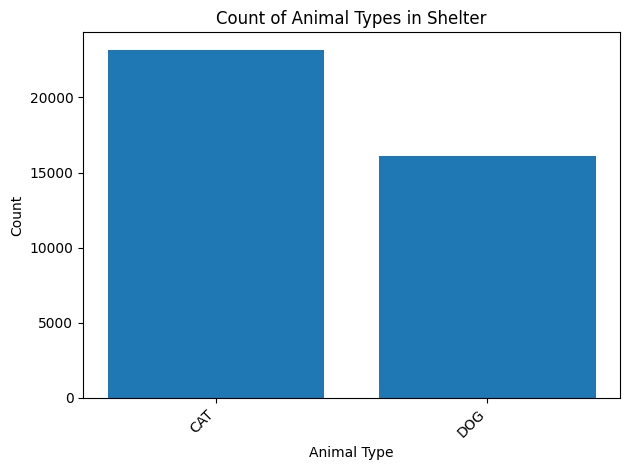

In [40]:
#count how many of each animal type there are
print(df['Animal Type'].value_counts())

#bar chart of animal types
plt.bar(df['Animal Type'].value_counts().index, df['Animal Type'].value_counts().values)
plt.xlabel('Animal Type')
plt.ylabel('Count')
plt.title('Count of Animal Types in Shelter')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Intake Condition
NORMAL                19982
UNDER AGE/WEIGHT       9187
ILL MILD               1820
INJURED  SEVERE        1396
ILL SEVERE             1184
ILL MODERATETE         1148
FRACTIOUS              1036
INJURED  MILD           952
INJURED  MODERATE       907
I/I REPORT              470
FERAL                   423
AGED                    246
BEHAVIOR  MODERATE      220
BEHAVIOR  SEVERE        113
BEHAVIOR  MILD          106
WELFARE SEIZURES         99
INTAKEEXAM                2
Name: count, dtype: int64


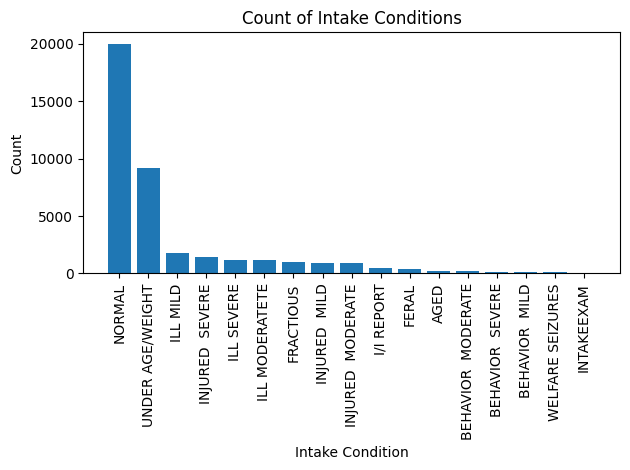

In [41]:
#look at intake conditions
print(df['Intake Condition'].value_counts())

#bar chart of intake conditions
plt.bar(df['Intake Condition'].value_counts().index, df['Intake Condition'].value_counts().values)
plt.xlabel('Intake Condition')
plt.ylabel('Count')
plt.title('Count of Intake Conditions')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#may need to remove null values for intake condition
#df = df[df['Intake Condition'].notnull()]

Intake Type
STRAY                    33070
OWNER SURRENDER           3759
WELFARE SEIZED             812
CONFISCATE                 610
RETURN                     555
QUARANTINE                 267
SAFE KEEP                  126
TRAP, NEUTER, RETURN        76
FOSTER                       6
Euthenasia Required          4
WILDLIFE                     3
Adopted Animal Return        3
Name: count, dtype: int64


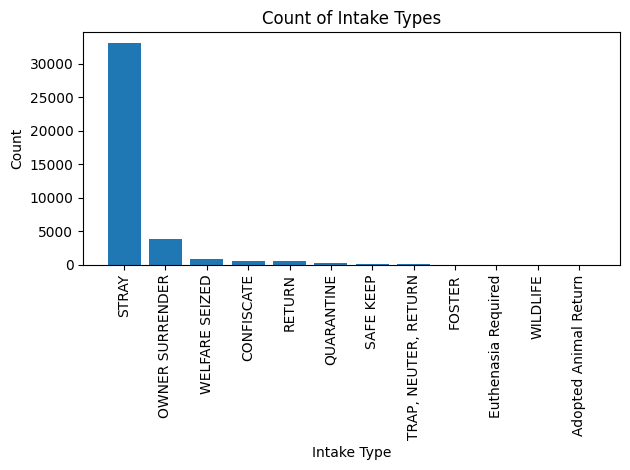

In [42]:
#look at intake types
print(df['Intake Type'].value_counts())

plt.bar(df['Intake Type'].value_counts().index, df['Intake Type'].value_counts().values)
plt.xlabel('Intake Type')
plt.ylabel('Count')
plt.title('Count of Intake Types')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [43]:
#percentage of cats vs dogs adopted
cats = df[df['Animal Type'] == 'CAT']
dogs = df[df['Animal Type'] == 'DOG']
print("Cats adopted:", cats[(cats['Outcome Type'] == 'ADOPTION') | (cats['Outcome Type'] == 'RESCUE')].shape[0] / cats.shape[0])
print("Dogs adopted:", dogs[(dogs['Outcome Type'] == 'ADOPTION') | (dogs['Outcome Type'] == 'RESCUE')].shape[0] / dogs.shape[0])

Cats adopted: 0.5414850929801096
Dogs adopted: 0.43688717885068884


Outcome Type
ADOPTION                   10310
RESCUE                      9280
TRANSFER                    5492
EUTHANASIA                  5176
RETURN TO OWNER             5146
SHELTER, NEUTER, RETURN     1349
COMMUNITY CAT                724
DIED                         719
FOSTER TO ADOPT              338
TRANSPORT                    279
HOMEFIRST                    140
MISSING                      105
RETURN TO RESCUE              70
TRAP, NEUTER, RELEASE         58
DUPLICATE                     44
DISPOSAL                      43
FOSTER                        10
RETURN TO WILD HABITAT         8
Name: count, dtype: int64


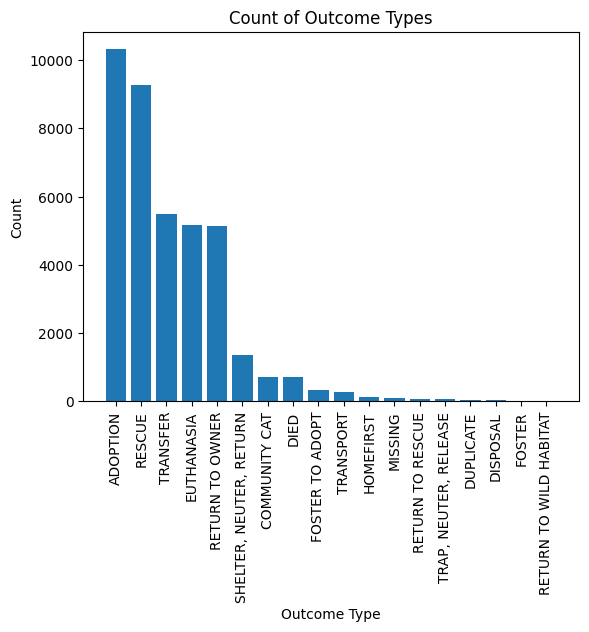

In [44]:
#look at outcome types
print(df['Outcome Type'].value_counts())

#bar chart of outcome types
plt.bar(df['Outcome Type'].value_counts().index, df['Outcome Type'].value_counts().values)
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.title('Count of Outcome Types')
plt.xticks(rotation=90)
plt.show()

Since intake duration is a key focus of our analysis, we should examine a summary of this feature, displayed below.

In [45]:
print(df['intake_duration'].describe())

count    39291.000000
mean        22.896643
std         52.611219
min          0.000000
25%          1.000000
50%          7.000000
75%         22.000000
max       1410.000000
Name: intake_duration, dtype: float64


Most animals have very short shelter stays, but a few animals stay much longer. The length of stay for some animals is so much higher than typical values that we must consider these outliers when analyzing the data.

The distribution below illustrates the effect that these few, but substantial, outliers have on understanding the data. In addition, is a closer look at the highest distribution.

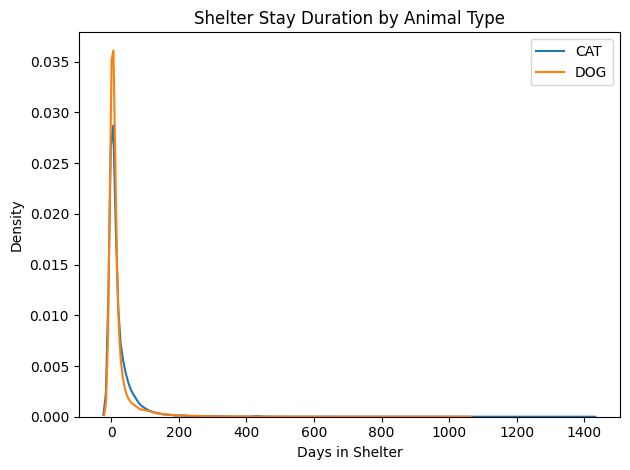

In [46]:
sns.kdeplot(data=df[df['Animal Type'] == 'CAT']['intake_duration'], label='CAT')
sns.kdeplot(data=df[df['Animal Type'] == 'DOG']['intake_duration'], label='DOG')

plt.xlabel('Days in Shelter')
plt.ylabel('Density')
plt.title('Shelter Stay Duration by Animal Type')
plt.legend()
plt.tight_layout()
plt.show()

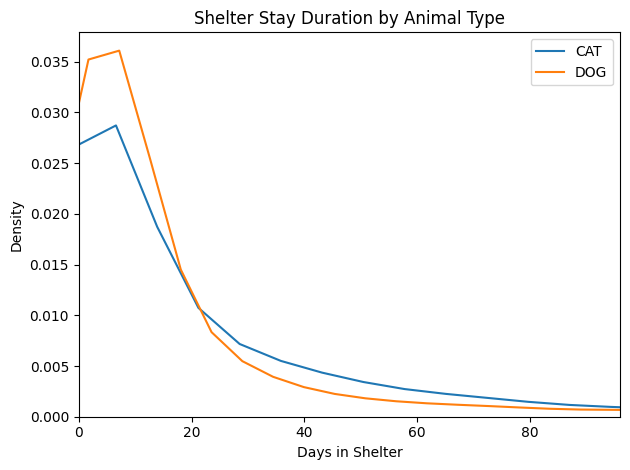

In [47]:


sns.kdeplot(data=df[df['Animal Type'] == 'CAT']['intake_duration'], label='CAT')
sns.kdeplot(data=df[df['Animal Type'] == 'DOG']['intake_duration'], label='DOG')

plt.xlabel('Days in Shelter')
plt.ylabel('Density')
plt.title('Shelter Stay Duration by Animal Type')
plt.legend()
plt.tight_layout()
plt.xlim(0, df['intake_duration'].quantile(0.95))
plt.show()

Below we are checking if there a simple linear relationship between the age at intake and the intake duration. There doesn't appear to be a strong linear correlation between age and length of stay.

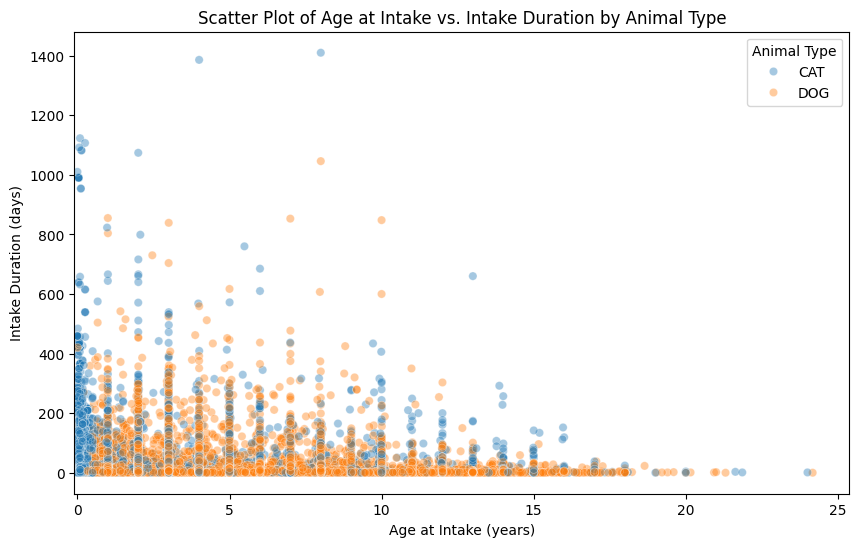

In [48]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age at Intake', y='intake_duration', hue='Animal Type', alpha=0.4)
plt.xlabel('Age at Intake (years)')
plt.ylabel('Intake Duration (days)')
plt.title('Scatter Plot of Age at Intake vs. Intake Duration by Animal Type')
plt.xlim(-0.1)
plt.show()


In [49]:
# Overall correlation
corr_overall = df['Age at Intake'].corr(df['intake_duration'])
print(f"Overall correlation: {corr_overall:.3f}")

# By animal type
for animal in ['CAT', 'DOG']:
    subset = df[df['Animal Type'] == animal]
    corr = subset['Age at Intake'].corr(subset['intake_duration'])
    print(f"{animal} correlation: {corr:.3f}")

# No strong linear correlation between age and length of stay.

Overall correlation: -0.014
CAT correlation: 0.033
DOG correlation: -0.032


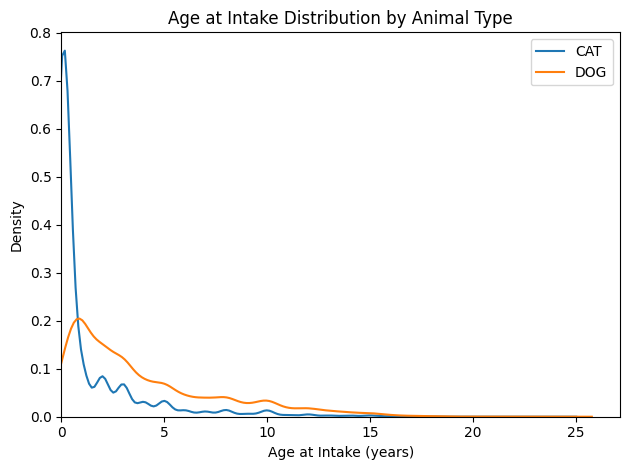

In [50]:
sns.kdeplot(data=df[df['Animal Type'] == 'CAT']['Age at Intake'], label='CAT')
sns.kdeplot(data=df[df['Animal Type'] == 'DOG']['Age at Intake'], label='DOG')

plt.xlabel('Age at Intake (years)')
plt.ylabel('Density')
plt.title('Age at Intake Distribution by Animal Type')
plt.legend()
plt.xlim(0)
plt.tight_layout()
plt.show()

Visualization of outcome type proportion by intake condition to see if there are any intake conditions which are strongly associated with specific outcomes.

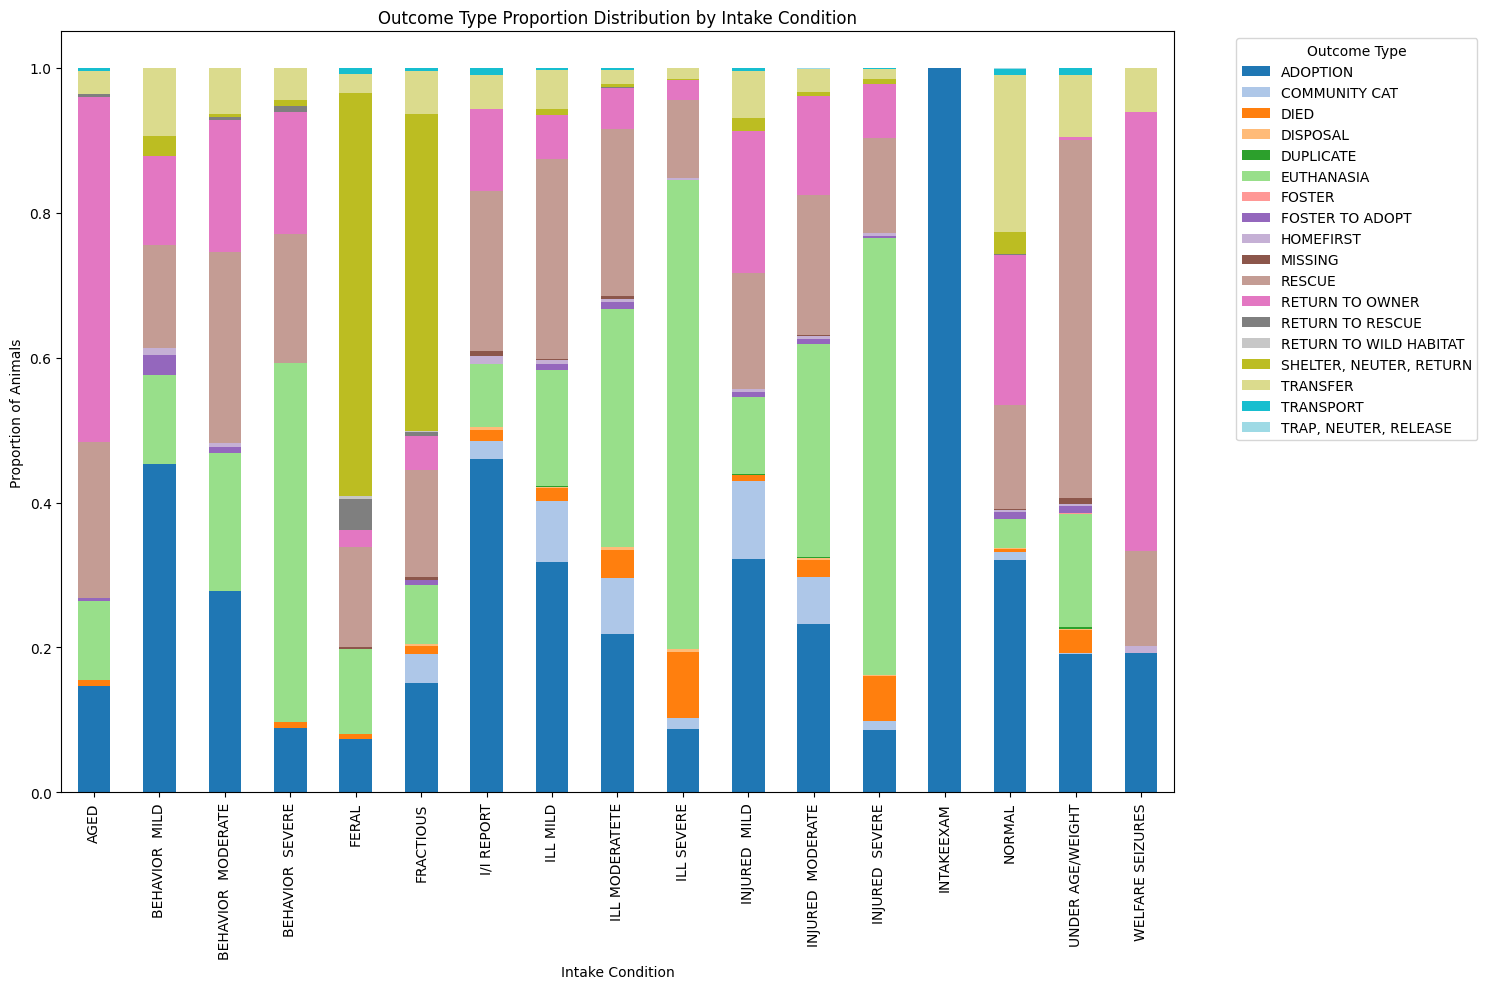

In [51]:
# Create a crosstab of Intake Condition and Outcome Type
intake_outcome_counts = pd.crosstab(df['Intake Condition'], df['Outcome Type'])

# Calculate proportions within each Intake Condition
intake_outcome_proportions = intake_outcome_counts.divide(intake_outcome_counts.sum(axis=1), axis=0)

# Plot a stacked bar chart of proportions with a colormap
intake_outcome_proportions.plot(kind='bar', stacked=True, figsize=(15, 10), cmap='tab20')

plt.xlabel('Intake Condition')
plt.ylabel('Proportion of Animals')
plt.title('Outcome Type Proportion Distribution by Intake Condition')
plt.xticks(rotation=90)
plt.legend(title='Outcome Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The model below uses Age at Intake as well as the Animal Type as predictors.

These predictors don't seem to do quite enough to account for the strong outliers we have and we are left with an RMSE of over 52, which is pretty high compared to a mean of 22

In [70]:
print(df['intake_duration'].describe())

#Select predictors and target
features = [    'Age at Intake',
    'Animal Type_DOG',
    'Sex',
    'Intake Condition',
    'Intake Type',
]
target = 'intake_duration'

# One-hot encode categorical variables
X = pd.get_dummies(df[features], drop_first=True)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

#Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Linear Regression
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred_linear = reg.predict(X_test)
rmse_linear = np.sqrt(np.mean((y_test - y_pred_linear)**2))

#knr
knr = KNeighborsRegressor(n_neighbors=9)
knr.fit(X_train, y_train)
y_pred_knr = knr.predict(X_test)
rmse_knr = np.sqrt(np.mean((y_test - y_pred_knr)**2))

print(f'\nLinear Regression RMSE: {rmse_linear:.2f}')
print(f'KNR RMSE: {rmse_knr:.2f}')

#the RMSE is incredibly high due to the significant outliers.


count    39291.000000
mean        22.896643
std         52.611219
min          0.000000
25%          1.000000
50%          7.000000
75%         22.000000
max       1410.000000
Name: intake_duration, dtype: float64

Training set size: (27503, 33)
Test set size: (11788, 33)

Linear Regression RMSE: 50.54
KNR RMSE: 51.75


We experiment with dropping outliers which results in a lower RMSE but we are losing some valuable data from animals that have legitimate long duration stays.

In [53]:
# Handle outliers using IQR
Q1 = df['intake_duration'].quantile(0.25)
Q3 = df['intake_duration'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_cleaned = df[(df['intake_duration'] >= lower_bound) & (df['intake_duration'] <= upper_bound)].copy()

print(df_cleaned['intake_duration'].describe())
print(f"Original data shape: {df.shape}")
print(f"Cleaned data shape: {df_cleaned.shape}")


X = df_cleaned[predictors].values
y = df_cleaned[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

#Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Linear Regression
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred_linear = reg.predict(X_test)
rmse_linear = np.sqrt(np.mean((y_test - y_pred_linear)**2))

#knr
knr = KNeighborsRegressor(n_neighbors=9)
knr.fit(X_train, y_train)
y_pred_knr = knr.predict(X_test)
rmse_knr = np.sqrt(np.mean((y_test - y_pred_knr)**2))

print(f'\nLinear Regression RMSE: {rmse_linear:.2f}')
print(f'KNR RMSE: {rmse_knr:.2f}')

#much lower RMSE and both KNR and Linear Regression performing similarly.
#but we're tossing data which could be important

count    34917.000000
mean        10.199072
std         12.344978
min          0.000000
25%          1.000000
50%          6.000000
75%         14.000000
max         53.000000
Name: intake_duration, dtype: float64
Original data shape: (39291, 15)
Cleaned data shape: (34917, 15)

Training set size: (24441, 2)
Test set size: (10476, 2)

Linear Regression RMSE: 12.39
KNR RMSE: 12.87


Test of a different model with more predictors. Slightly improved RMSE but not much

MAE: 22.002769102331847
R²: -0.012745305311588462
RMSE: 49.79


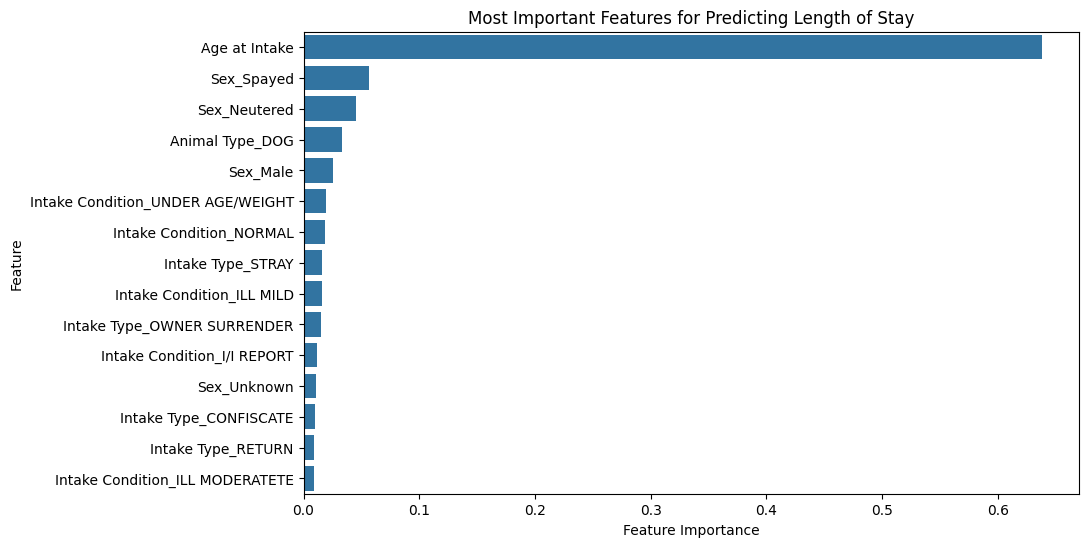

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

features = [    'Age at Intake',
    'Animal Type_DOG',
    'Sex',
    'Intake Condition',
    'Intake Type',
]
target = 'intake_duration'

# One-hot encode categorical variables
X = pd.get_dummies(df[features], drop_first=True)
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances[:15], y=importances.index[:15])
plt.title('Most Important Features for Predicting Length of Stay')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

Visualization of some of the lengthy stays that are causing problems with our model.

There 10 animals with extremely lengthy stays of over 1000 days.

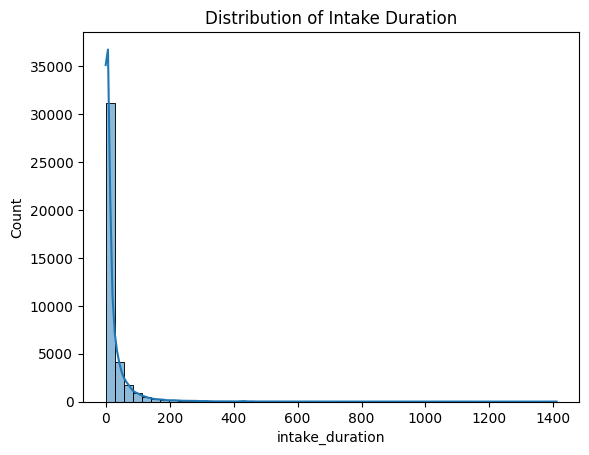

,Animal Type,Primary Color,Sex,DOB,Intake Date,Intake Condition,Intake Type,Outcome Type,latitude,longitude,intake_duration,outcome_is_alive,outcome_is_dead,Age at Intake,Animal Type_DOG
4686,CAT,ORG TABBY,Neutered,2012-03-23,2020-03-23,INJURED MODERATE,STRAY,ADOPTION,33.820491,-118.169570,1410.0,True,False,8.000000,False
6527,DOG,BROWN,Male,2011-08-14,2019-08-14,ILL MODERATETE,STRAY,RESCUE,33.872665,-118.072327,1046.0,True,False,8.000000,True
16745,CAT,ORG TABBY,Neutered,2016-02-13,2020-02-13,NORMAL,STRAY,ADOPTION,33.781783,-118.158690,1386.0,True,False,4.000000,False
22476,CAT,BRN TABBY,Female,2017-08-01,2019-08-01,NORMAL,STRAY,ADOPTION,33.826713,-118.193179,1074.0,True,False,1.998631,False
22739,CAT,BRN TABBY,Male,2019-05-16,2019-06-16,FRACTIOUS,STRAY,ADOPTION,33.810680,-118.112907,1123.0,True,False,0.084873,False
28185,CAT,BLACK,Male,2019-06-06,2019-07-24,UNDER AGE/WEIGHT,STRAY,ADOPTION,33.858119,-118.197609,1082.0,True,False,0.131417,False
28187,CAT,WHITE,Male,2019-06-06,2019-07-24,UNDER AGE/WEIGHT,STRAY,ADOPTION,33.858119,-118.197609,1082.0,True,False,0.131417,False
30240,CAT,GRAY TABBY,Female,2019-03-30,2019-06-29,NORMAL,STRAY,ADOPTION,33.778972,-118.186368,1107.0,True,False,0.249144,False
41247,CAT,BLACK,Unknown,2019-08-21,2019-09-11,UNDER AGE/WEIGHT,STRAY,ADOPTION,33.795304,-118.187197,1092.0,True,False,0.057495,False
46731,CAT,BLACK,Unknown,2019-09-20,2019-09-20,UNDER AGE/WEIGHT,STRAY,MISSING,33.851891,-118.178370,1010.0,False,False,0.000000,False


In [55]:
sns.histplot(df['intake_duration'], bins=50, kde=True)
plt.title('Distribution of Intake Duration')
plt.show()

df['intake_duration'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

df[df['intake_duration'] < 0]        # should already be removed
df[df['intake_duration'] > 1000]     # check extreme long stays

As an alternative to dropping the data, we are going to clip intake_duration to the 99th percentile of intake duration so that we are keeping those long stays but they aren't as influential on our model.

Our original intake_duration max is 1410 and now clipped to 238 max. We see a big improvement in RMSE.

In [56]:
# Let's just try clipping at the 99th percentile

upper_limit = df['intake_duration'].quantile(0.99)

df_clipped = df.copy()

df_clipped['intake_duration'] = df_clipped['intake_duration'].clip(upper=upper_limit)

# 4. Optional: confirm that clipping worked
print("Original max:", df['intake_duration'].max())
print("Clipped max:", df_clipped['intake_duration'].max())

#Select predictors and target
predictors = ['Age at Intake', 'Animal Type_DOG']
target = 'intake_duration'

X = df_clipped[predictors].values
y = df_clipped[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

#Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Linear Regression
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred_linear = reg.predict(X_test)
rmse_linear = np.sqrt(np.mean((y_test - y_pred_linear)**2))

#knr
knr = KNeighborsRegressor(n_neighbors=9)
knr.fit(X_train, y_train)
y_pred_knr = knr.predict(X_test)
rmse_knr = np.sqrt(np.mean((y_test - y_pred_knr)**2))

print(f'\nLinear Regression RMSE: {rmse_linear:.2f}')
print(f'KNR RMSE: {rmse_knr:.2f}')

Original max: 1410.0
Clipped max: 238.0

Training set size: (27503, 2)
Test set size: (11788, 2)

Linear Regression RMSE: 37.00
KNR RMSE: 38.72


Testing other regression models to find improvements.

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

features = [
    'Age at Intake',
    'Animal Type_DOG',
    'Sex',
    'Intake Condition',
    'Intake Type',
]
target = 'intake_duration'

# One-hot encode categorical variables
X = pd.get_dummies(df_clipped[features], drop_first=True)
y = df_clipped[target]



# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

print(df_clipped['intake_duration'].describe())

MAE: 19.511009521753913
R²: 0.038542080720359695
RMSE: 34.90
count    39291.000000
mean        21.341961
std         38.533672
min          0.000000
25%          1.000000
50%          7.000000
75%         22.000000
max        238.000000
Name: intake_duration, dtype: float64


In [58]:
baseline_rmse = np.sqrt(np.mean((y_test - y_test.mean())**2))
print("Baseline RMSE:", baseline_rmse)

Baseline RMSE: 35.59309234721293


In [59]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest -> RMSE: {rmse_rf:.2f}, R²: {r2_rf:.3f}")

Random Forest -> RMSE: 34.90, R²: 0.039


Gradient Boosting Regressor gives us our best result.

In [60]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.03,
    subsample=0.8,
    max_depth=5,
    random_state=42
)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting -> RMSE: {rmse_gb:.2f}, R²: {r2_gb:.3f}")

Gradient Boosting -> RMSE: 32.98, R²: 0.141


In [61]:
def evaluate_model(y_test, y_pred, model):
    accuracy = np.mean(y_pred == y_test)
    print(f'Classification Accuracy: {accuracy:.2f}')
    print(classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

Regression Model Performance Comparison:


,Model,RMSE,R²
4,Gradient Boosting Regressor,32.979087,0.141489
3,Random Forest Regressor,34.897256,0.038717
0,Baseline (Mean Prediction),35.593092,0.000000
1,Linear Regression,50.537946,0.059917
2,K-Nearest Neighbors Regressor,51.754605,0.014109


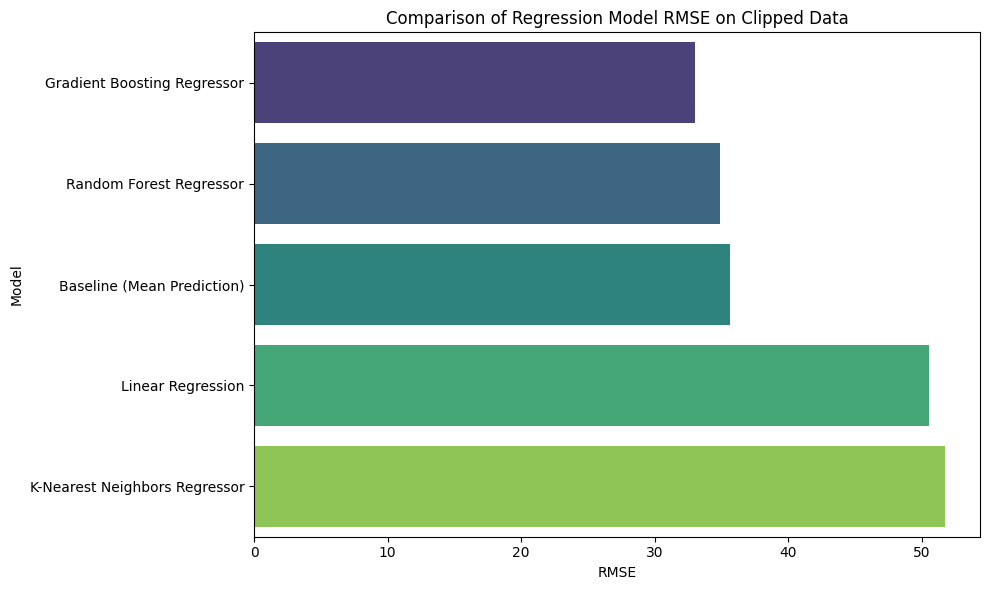

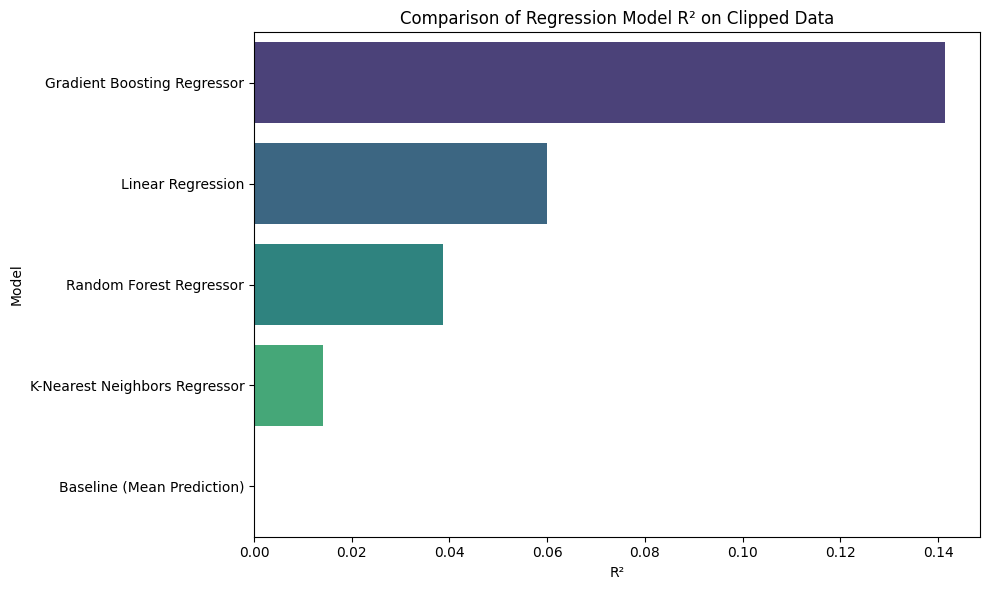

In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score


# Create a DataFrame to store model performance metrics
model_performance = pd.DataFrame({
        'Model': ['Baseline (Mean Prediction)', 'Linear Regression', 'K-Nearest Neighbors Regressor', 'Random Forest Regressor', 'Gradient Boosting Regressor'],
        'RMSE': [baseline_rmse, rmse_linear, rmse_knr, rmse_rf, rmse_gb],
        'R²': [0, r2_score(y_test, reg.predict(X_test)), r2_score(y_test, knr.predict(X_test)), r2_rf, r2_gb] # Calculate R2 for Linear Reg and KNR on clipped data
    })

#Sort by RMSE for better visualization
model_performance = model_performance.sort_values('RMSE', ascending=True)

print("Regression Model Performance Comparison:")
display(model_performance)

# Plot RMSE comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='RMSE', y='Model', hue='Model', data=model_performance, palette='viridis')
plt.xlabel('RMSE')
plt.ylabel('Model')
plt.title('Comparison of Regression Model RMSE on Clipped Data')
plt.tight_layout()
plt.show()

# Plot R² comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='R²', y='Model', hue='Model', data=model_performance.sort_values('R²', ascending=False), palette='viridis')
plt.xlabel('R²')
plt.ylabel('Model')
plt.title('Comparison of Regression Model R² on Clipped Data')
plt.tight_layout()
plt.show()


We also want to see if we can predict whether an animal is going to die while in the shelter based on our same predictors.

Training set size: (27503, 33)
Test set size: (11788, 33)

Logistic Regression Model Performance for Predicting Outcome is Dead:
              precision    recall  f1-score   support

       False       0.90      0.98      0.94     10006
        True       0.80      0.38      0.52      1782

    accuracy                           0.89     11788
   macro avg       0.85      0.68      0.73     11788
weighted avg       0.88      0.89      0.88     11788

Accuracy: 0.8923
ROC AUC Score: 0.8747


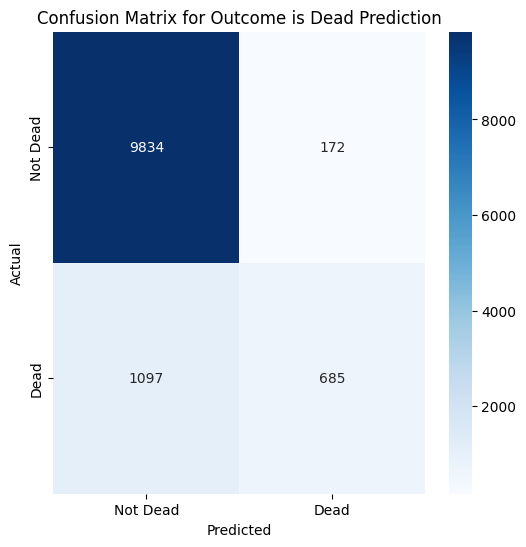

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, balanced_accuracy_score

# Select features and the new target variable
features = [
    'Age at Intake',
    'Animal Type_DOG',
    'Sex',
    'Intake Condition',
    'Intake Type',
]
target = 'outcome_is_dead'

X = pd.get_dummies(df_clipped[features], drop_first=True)
y = df_clipped[target].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Train Logistic Regression model
log_reg_death = LogisticRegression(max_iter=1000, random_state=42)
log_reg_death.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_death = log_reg_death.predict(X_test_scaled)
y_pred_proba_death = log_reg_death.predict_proba(X_test_scaled)[:, 1] # Get probabilities for the positive class

# Evaluate the model
print("\nLogistic Regression Model Performance for Predicting Outcome is Dead:")
print(classification_report(y_test, y_pred_death))

accuracy = accuracy_score(y_test, y_pred_death)
roc_auc = roc_auc_score(y_test, y_pred_proba_death)

print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')

# Display Confusion Matrix
cm_death = confusion_matrix(y_test, y_pred_death)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_death, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Dead', 'Dead'], yticklabels=['Not Dead', 'Dead'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Outcome is Dead Prediction')
plt.show()


With high precision and high recall for the "Not Dead" classification, our model is quite good at correctly identifying animals that will survive.

For our "Dead" classification, we have high precision but lower recall. This means our model is likely to be correct when it predicts death, but it misses many animals that actually die.

This is probably not ideal for a shelter where we would want to **identify as many animals at risk of dying as possible (high recall), even if it means some false positives (predicting death for an animal that survives). Missing a true positive (an animal that dies) could mean missing an opportunity for timely intervention or care.**

The following is a threshold tuned model where we prioritize recall for predicting a death outcome.


Logistic Regression Model Performance for Predicting Outcome is Dead (Threshold = 0.1):
              precision    recall  f1-score   support

       False      0.968     0.704     0.815     10006
        True      0.343     0.868     0.492      1782

    accuracy                          0.729     11788
   macro avg      0.656     0.786     0.654     11788
weighted avg      0.873     0.729     0.766     11788

Accuracy: 0.7290
ROC AUC Score: 0.8747


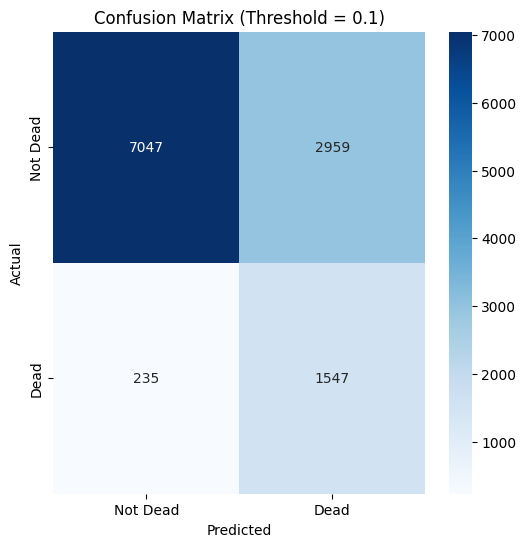

In [63]:

# Define the new threshold
new_threshold = 0.10

# Generate predictions based on the new threshold
y_pred_death_threshold = (y_pred_proba_death >= new_threshold).astype(int)

# -------------------------------
# Evaluate the model at new threshold
# -------------------------------
print(f"\nLogistic Regression Model Performance for Predicting Outcome is Dead (Threshold = {new_threshold}):")
print(classification_report(y_test, y_pred_death_threshold, digits=3))

accuracy = accuracy_score(y_test, y_pred_death_threshold)
roc_auc = roc_auc_score(y_test, y_pred_proba_death)

print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')

# -------------------------------
# Confusion Matrix at new threshold
# -------------------------------
cm_death = confusion_matrix(y_test, y_pred_death_threshold)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_death, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Dead', 'Dead'], yticklabels=['Not Dead', 'Dead'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {new_threshold})')
plt.show()

Visualization of what features are important in our prediction of outcome

Feature Importance (Coefficients) from Logistic Regression for Predicting Outcome is Dead:
                              feature  coefficient
4                          Sex_Spayed    -0.998303
3                        Sex_Neutered    -0.892994
1                     Animal Type_DOG    -0.652129
17   Intake Condition_INJURED  SEVERE     0.521926
14        Intake Condition_ILL SEVERE     0.499817
0                       Age at Intake     0.485571
5                         Sex_Unknown     0.374407
21  Intake Condition_WELFARE SEIZURES    -0.365739
19            Intake Condition_NORMAL    -0.296419
13    Intake Condition_ILL MODERATETE     0.279270


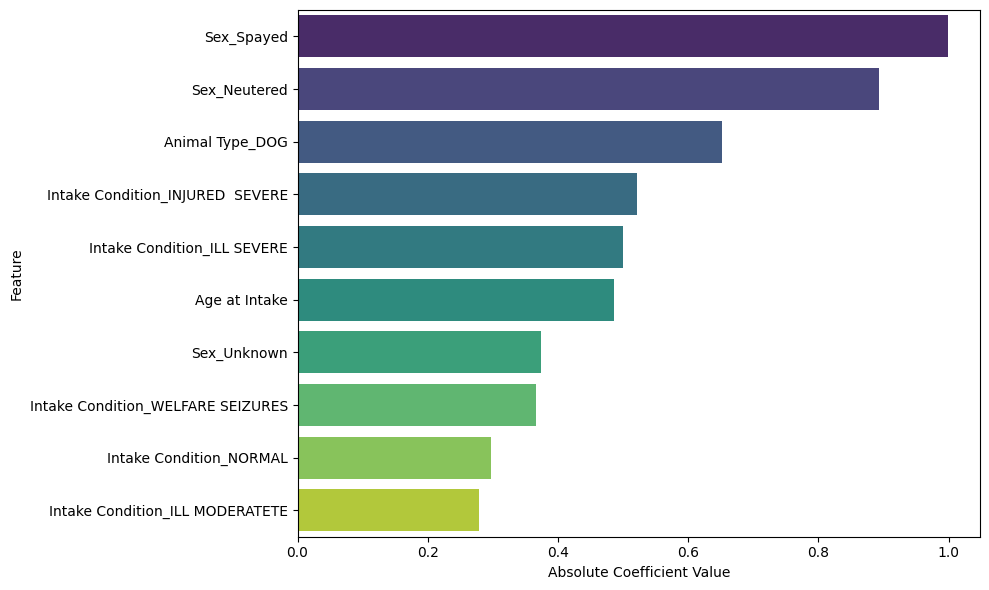

In [75]:
    # Get the coefficients
coefficients = log_reg_death.coef_[0]

    # Get the feature names from the one-hot encoded DataFrame X
feature_names = X.columns

    # Create a DataFrame of features and their coefficients
feature_importance_log_reg = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

    # Calculate absolute coefficients for ranking importance
feature_importance_log_reg['abs_coefficient'] = abs(feature_importance_log_reg['coefficient'])

    # Sort by absolute coefficient in descending order
feature_importance_log_reg = feature_importance_log_reg.sort_values('abs_coefficient', ascending=False)

print("Feature Importance (Coefficients) from Logistic Regression for Predicting Outcome is Dead:")
print(feature_importance_log_reg[['feature', 'coefficient']].head(10)) # Display top 10 features

    # Optional: Visualize feature importances (absolute coefficients)
plt.figure(figsize=(10, 6))
sns.barplot(x='abs_coefficient', y='feature', hue='feature', data=feature_importance_log_reg.head(10), palette='viridis')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Classification Accuracy: 0.87
              precision    recall  f1-score   support

   0-45 days       0.88      0.98      0.93     10272
  46-65 days       0.22      0.03      0.06       529
    65+ days       0.32      0.08      0.13       987

    accuracy                           0.87     11788
   macro avg       0.48      0.37      0.37     11788
weighted avg       0.81      0.87      0.82     11788



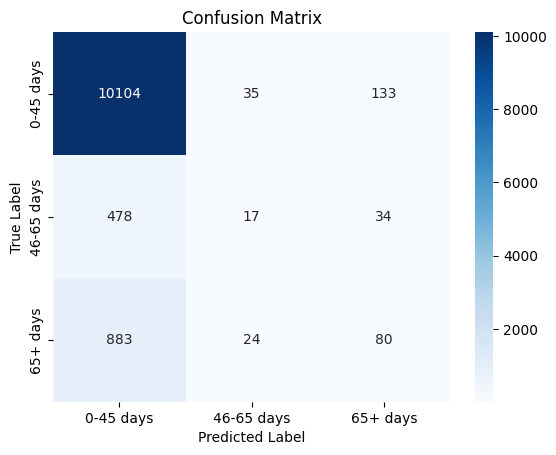

In [65]:
#Hopefully a very accurate classifier
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output = False)

predictors = [
    'Age at Intake',
    'Animal Type_DOG',
    'Sex',
    'Intake Condition',
    'Intake Type',
]


df['stay_category'] = pd.cut(df['intake_duration'], bins=[-1, 45, 65, np.inf], labels=['0-45 days', '46-65 days', '65+ days'])
X_categorical = encoder.fit_transform(df[predictors].select_dtypes(include=['object', 'category']))
X_numerical = df[predictors].select_dtypes(include=['number']).values
X = np.hstack((X_numerical, X_categorical))
y = df['stay_category'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#use KNeighbors Classifier
knc = KNeighborsClassifier(n_neighbors=7)
knc.fit(X_train, y_train)
y_pred = knc.predict(X_test)
evaluate_model(y_test, y_pred, knc)